In [92]:
# !pip install tqdm==4.28.1
# !pip install -U gast==0.2.2
# !pip install gdown

# !gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
# !mkdir datasets
# !tar -C datasets -xzf airport-alunos.tgz


In [1]:
#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


from sklearn.datasets import load_sample_image;

import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

2.0.0
4.28.1


In [12]:
def create_base_model(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Conv2D(8, (3, 3), activation = None, padding='same')(input_layer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(16, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(32, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(64, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model

### Defining S1 with TripletLoss

In [124]:
class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TripletLossLayer, self).__init__()
    
    def euclidean_distance(self, vects):
        x, y = vects
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')
        sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))

    def call(self, inputs=None):
        #     a, p, n = inp
        #     Calcule triplet loss 
        #     loss = max(dist(a, p) - dist(a, n) + margin, 0)
        self.margin = tf.constant(1000 , dtype='float32')
        a, p, n = inputs
        a = tf.cast(a, 'float32')
        p = tf.cast(p, 'float32')
        n = tf.cast(n, 'float32')
        # Calcule triplet loss 
        # loss = max(dist(a, p) - dist(a, n) + margin, 0)
        subt_ = tf.subtract(self.euclidean_distance([a, p]) , self.euclidean_distance([a, n]))
        sum_ = tf.add(subt_, self.margin)
        loss = sum_#, tf.constant(0)

        # add in model loss
        self.add_loss(loss)
    
        return a

In [125]:
input_shape = (28, 28, 1)
base_network = create_base_model(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_a = base_network(input_anchor)
processed_p = base_network(input_positive)
processed_n = base_network(input_negative)

# loss = Lambda(triplet_loss)([processed_a, processed_p, processed_n])
loss_layer = TripletLossLayer()([processed_a, processed_p, processed_n])

model = Model([input_anchor, input_positive, input_negative], loss_layer)


In [126]:
model.compile(loss=(lambda y_true, ypred: 0.0))
# base_network.compile(loss='mse')

In [127]:
tf.keras.utils.plot_model(model)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_14 (Model)                (None, 64)           29024       input_30[0][0]                   
                                                                 input_31[0][0]            

In [114]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float')

In [128]:
# base_network.fit(x_train, y_train, batch_size=1)
inp_ = [x_train[1000+i].reshape(1, 28,28,1) for i in range(3)]
y_true = np.array([[0.0 for _ in range(64)]])


In [130]:
model.train_on_batch(inp_, y_true)

array([[998.208]], dtype=float32)

In [5]:
file_names_treino = !find datasets/airport-alunos/treino -name '???.png' | sort
file_names_val = !find datasets/airport-alunos/val -name '???.png' | sort

print(file_names_treino[:2])
print(file_names_val[:2])

['datasets/airport-alunos/treino/0/000/000.png', 'datasets/airport-alunos/treino/0/000/001.png']
['datasets/airport-alunos/val/0/200/000.png', 'datasets/airport-alunos/val/0/200/001.png']


In [6]:
#load_sample_image('datasets/airport-alunos/treino/0/094/051.png')

#tf.image.decode_image(tf.io.read_file('datasets/airport-alunos/treino/0/094/051.png'))

In [ ]:
from dataset_utils import person_to_img
from dataset_utils import combine_cam_files
from dataset_utils import get_batch
from dataset_utils import plot_sample

# carrega imagens para memória
cam_img_dict_treino, pids1_treino, pids2_treino = person_to_img(file_names_treino)
cam_img_dict_val, pids1_val, pids2_val = person_to_img(file_names_val)

In [12]:
# gera listas de similares e dissimilares na memória
d_combination_treino = combine_cam_files(pids1_treino, pids2_treino)
d_combination_val = combine_cam_files(pids1_val, pids2_val)

100%|██████████| 2824/2824 [00:02<00:00, 1013.71it/s]


In [ ]:
# obtem pares de batches apartir das imagens em memória
X_a_treino, X_b_treino, y_treino = get_batch(d_combination_treino, cam_img_dict_treino)
X_a_val, X_b_val, y_val = get_batch(d_combination_val, cam_img_dict_val)

In [10]:
plot_sample(X_a_treino/255, X_b_treino/255, y_treino)

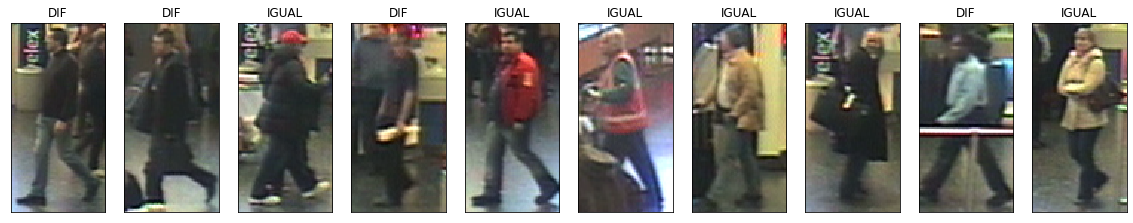

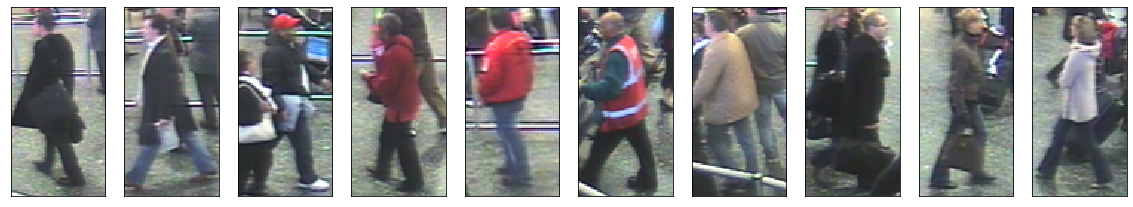

In [10]:
plot_sample(X_a_val/255, X_b_val/255, y_val)